In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import pymc as pm
import arviz as az
from scipy.stats import norm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [49]:
diab = load_diabetes(as_frame=True)
df = diab.frame.copy()
df.rename(columns={"target": "y"}, inplace=True)
X = df[['bmi']]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

In [50]:
X_train_sm = sm.add_constant(X_train)
X_test_sm  = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     182.6
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.09e-33
Time:                        10:32:23   Log-Likelihood:                -1839.1
No. Observations:                 331   AIC:                             3682.
Df Residuals:                     329   BIC:                             3690.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.9265      3.454     43.985      0.0

In [51]:
pred_ols = ols_model.get_prediction(X_test_sm).summary_frame(alpha=0.05)
pred_ols.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
117,131.389772,3.804792,123.904984,138.874561,7.574926,255.204618
349,96.049626,5.447109,85.334069,106.765183,-28.002449,220.101701
400,195.833568,4.688359,186.610625,205.056511,71.901503,319.765633
116,208.306561,5.355983,197.770268,218.842854,84.269842,332.343280
192,122.035028,4.143360,113.884207,130.185848,-1.821866,245.891921


Assume priors:
$$
\beta_j\sim\mathcal{N}(0,\tau^2),\;\;\;\sigma\sim\mathrm{HalfNormal}(s)
$$
as $\sigma$ has to be positive. Notably, the likelihood is the same for a Bayesian linear model:
$$
y_i|\beta,\sigma\sim\mathcal{N}(x_i^\intercal\beta,\sigma^2)
$$
The posterior is then given by:
$$
p(\beta,\sigma|X,y)\propto p(y|X,\beta,\sigma)p(\beta)p(\sigma)
$$

In [52]:
x = np.asarray(X_train).reshape(-1)       # 1D
y = np.asarray(y_train)

x_mean, x_sd = x.mean(), x.std()
y_mean, y_sd = y.mean(), y.std()

x_mean, x_sd, y_mean, y_sd

(np.float64(0.0010912569142438814),
 np.float64(0.04838873028612807),
 np.float64(152.97885196374622),
 np.float64(78.10688416115951))

In [53]:
with pm.Model() as bayes_lm:
    X_data = pm.Data("X", X_train)
    y_data = pm.Data("y", y_train.values)

    # Priors
    beta0 = pm.Normal("beta0", mu=y_mean, sigma=2*y_sd)
    beta1  = pm.Normal("beta",  mu=0, sigma=y_sd / x_sd)
    sigma = pm.HalfNormal("sigma", sigma=y_sd)

    # Linear predictor
    mu = beta0 + beta1 * X_data[:, 0] #\mu of dist is x^T\beta
    # Add an intercept, homogeneous transform

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    # Posterior sampling
    idata = pm.sample(2000, tune=2000, target_accept=0.9)

az.summary(idata, var_names=["beta0", "beta", "sigma"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 309 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,151.925,3.381,145.699,158.644,0.035,0.036,9319.0,6380.0,1.0
beta,961.742,71.562,825.769,1096.594,0.760,0.781,8861.0,6173.0,1.0
sigma,62.981,2.442,58.398,67.423,0.026,0.026,8809.0,6055.0,1.0


In [54]:
X_test_arr = X_test.to_numpy().reshape(-1, 1).T
with bayes_lm:
    pm.set_data({"X": X_test_arr})
    ppc = pm.sample_posterior_predictive(idata, var_names=["y_obs", "beta0", "beta", "sigma"])


Sampling: [beta, beta0, sigma, y_obs]


Output()

In [55]:
sigma_hat = np.sqrt(ols_model.mse_resid)
lpd_ols = norm.logpdf(y_test.values, loc=ols_model.predict(X_test_sm), scale=sigma_hat).sum()

with bayes_lm:
    post = idata.posterior.stack(sample=("chain","draw"))
    beta0_s = post["beta0"].values 
    beta_s  = post["beta"].values
    sigma_s = post["sigma"].values

Xtest = np.asarray(X_test_s).reshape(-1) 
mu_draws = beta0_s[:, None] + beta_s[:, None] * Xtest[None, :] 


In [56]:
ypp = ppc.posterior_predictive["y_obs"].stack(sample=("chain","draw")).values  # typically (n_test, n_samples)
if ypp.shape[0] == len(y_test):   # (n_test, n_samples)
    ypp = ypp.T        
y_bayes_mean = ypp.mean(axis=0)
y_bayes_lo   = np.quantile(ypp, 0.025, axis=0)
y_bayes_hi   = np.quantile(ypp, 0.975, axis=0)


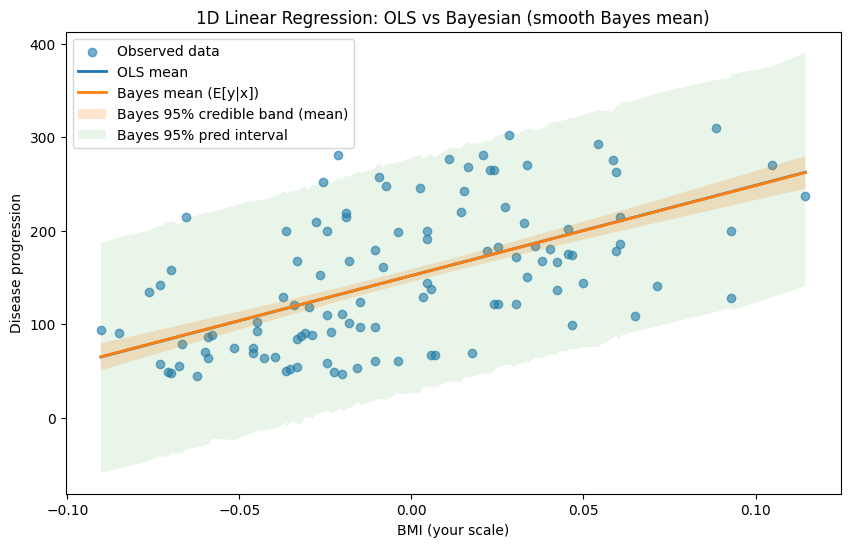

In [65]:
# ---- sort by x for a clean 1D plot ----
x_test = np.asarray(X_test).reshape(-1)   # (n_test,)
order = np.argsort(x_test)

x_sorted = x_test[order]
y_sorted = y_test.values[order]

# ---- OLS mean + prediction interval (already computed via statsmodels) ----
y_ols_mu = pred_ols["mean"].values[order]
y_ols_lo = pred_ols["obs_ci_lower"].values[order]
y_ols_hi = pred_ols["obs_ci_upper"].values[order]

# ---- Bayesian: compute posterior mean function mu(x) (NO observation noise) ----
post = idata.posterior.stack(sample=("chain", "draw"))

beta0_s = post["beta0"].values               # (n_samples,)
beta1_s = post["beta"].values                # (n_samples,)   <-- use "beta1" if you named it that
sigma_s = post["sigma"].values               # (n_samples,)

# draws of mu(x): (n_samples, n_test)
mu_draws = beta0_s[:, None] + beta1_s[:, None] * x_sorted[None, :]

# credible band for the mean function
mu_mean = mu_draws.mean(axis=0)
mu_lo   = np.quantile(mu_draws, 0.025, axis=0)
mu_hi   = np.quantile(mu_draws, 0.975, axis=0)

# ---- Optional: Bayesian posterior predictive interval (adds noise) ----
# This is comparable to OLS obs_ci_* (prediction interval for a new y)
yrep_draws = mu_draws + np.random.normal(0, sigma_s[:, None], size=mu_draws.shape)
yrep_lo = np.quantile(yrep_draws, 0.025, axis=0)
yrep_hi = np.quantile(yrep_draws, 0.975, axis=0)

# ---- plot ----
plt.figure(figsize=(10,6))
plt.scatter(x_sorted, y_sorted, alpha=0.6, label="Observed data")

# OLS
plt.plot(x_sorted, y_ols_mu, linewidth=2, label="OLS mean")

# Bayes: smooth mean + mean credible band
plt.plot(x_sorted, mu_mean, linewidth=2, label="Bayes mean (E[y|x])")
plt.fill_between(x_sorted, mu_lo, mu_hi, alpha=0.20, label="Bayes 95% credible band (mean)")

# Bayes: predictive interval (optional but useful)
plt.fill_between(x_sorted, yrep_lo, yrep_hi, alpha=0.10, label="Bayes 95% pred interval")

plt.xlabel("BMI (your scale)")
plt.ylabel("Disease progression")
plt.title("1D Linear Regression: OLS vs Bayesian (smooth Bayes mean)")
plt.legend()
plt.show()

In [66]:
# Posterior samples
post = idata.posterior.stack(sample=("chain", "draw"))

beta0_s = post["beta0"].values
beta1_s = post["beta"].values    # or "beta1"
sigma_s = post["sigma"].values

# OLS estimates
beta0_ols = ols_model.params[0]
beta1_ols = ols_model.params[1]
sigma_ols = np.sqrt(ols_model.mse_resid)


C:\Users\ADEY\AppData\Local\Temp\ipykernel_20904\3749570932.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0_ols = ols_model.params[0]
C:\Users\ADEY\AppData\Local\Temp\ipykernel_20904\3749570932.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta1_ols = ols_model.params[1]


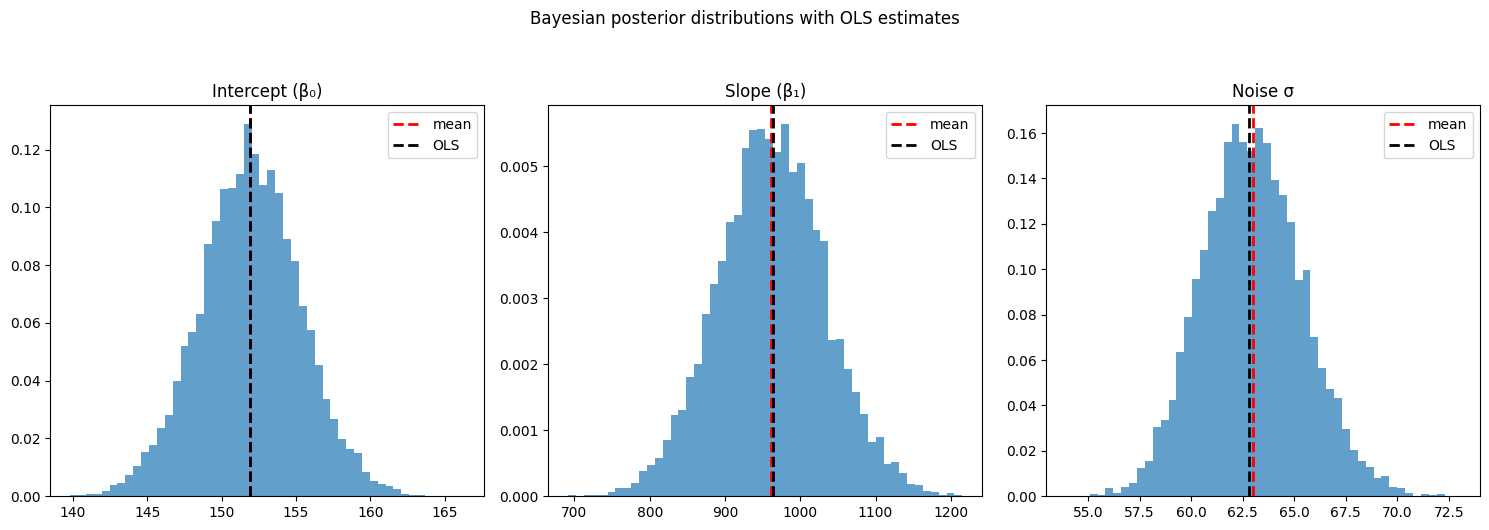

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ---- Intercept ----
axes[0].hist(beta0_s, bins=50, density=True, alpha=0.7)
axes[0].axvline(np.mean(beta0_s), color="red", linestyle="--", linewidth=2, label="mean")
axes[0].axvline(beta0_ols, color="black", linestyle="--", linewidth=2, label="OLS")
axes[0].set_title("Intercept (β₀)")
axes[0].legend()

# ---- Slope ----
axes[1].hist(beta1_s, bins=50, density=True, alpha=0.7)
axes[1].axvline(np.mean(beta1_s), color="red", linestyle="--", linewidth=2, label="mean")
axes[1].axvline(beta1_ols, color="black", linestyle="--", linewidth=2, label="OLS")
axes[1].set_title("Slope (β₁)")
axes[1].legend()

# ---- Noise ----
axes[2].hist(sigma_s, bins=50, density=True, alpha=0.7)
axes[2].axvline(np.mean(sigma_s), color="red", linestyle="--", linewidth=2, label="mean")
axes[2].axvline(sigma_ols, color="black", linestyle="--", linewidth=2, label="OLS")
axes[2].set_title("Noise σ")
axes[2].legend()

plt.suptitle("Bayesian posterior distributions with OLS estimates", y=1.05)
plt.tight_layout()
plt.show()
